In [1]:
from google.colab import drive
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
import os
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.optimizers import Adam

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the saved models
model_1 = tf.keras.models.load_model('/content/drive/MyDrive/EfficientNetB0_finetuned.keras')
model_2 = tf.keras.models.load_model('/content/drive/MyDrive/VGG16.keras')
model_3 = tf.keras.models.load_model('/content/drive/MyDrive/InceptionV3.keras')

In [5]:
# Unzip dataset
zip_path = '/content/drive/MyDrive/LC25000.zip'
extract_path = '/content/lc2500_dataset'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [6]:
# Initialize the validation data generator
lung_images_path = '/content/lc2500_dataset/lung_colon_image_set/lung_image_sets'
val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    lung_images_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important to keep the same order for predictions
)

Found 15000 images belonging to 3 classes.


In [50]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  #
)


train_generator = train_datagen.flow_from_directory(
    lung_images_path,  # Path to lung cancer data
    target_size=(224, 224),  # Resize images to match model input size
    batch_size=32,
    class_mode='categorical',
    subset='training'
)


validation_generator = train_datagen.flow_from_directory(
    lung_images_path,  # Path to lung cancer data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [7]:
# Step 1: Generate predictions for each model
probs_1 = model_1.predict(validation_generator)
probs_2 = model_2.predict(validation_generator)
probs_3 = model_3.predict(validation_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 151ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 89s 164ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 69s 138ms/step


In [8]:
# Step 2: Prepare feature matrix for logistic regression
X_val = np.concatenate([probs_1, probs_2, probs_3], axis=1)
y_val = validation_generator.classes  # True labels for validation set

In [9]:
# Step 3: Train Logistic Regression on the stacked model predictions
meta_classifier = LogisticRegression(max_iter=1000)
meta_classifier.fit(X_val, y_val)

LogisticRegression(max_iter=1000)

In [10]:
# Step 4: Evaluate the logistic regression model
ensemble_preds = meta_classifier.predict(X_val)
ensemble_accuracy = accuracy_score(y_val, ensemble_preds)

In [11]:
# Step 5: Calculate accuracy, confusion matrix, classification report
print("Stacking Ensemble Accuracy with Logistic Regression:", ensemble_accuracy)

Stacking Ensemble Accuracy with Logistic Regression: 0.9854666666666667


In [12]:
# Confusion Matrix
cm = confusion_matrix(y_val, ensemble_preds)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[4887    0  113]
 [   7 4993    0]
 [  98    0 4902]]


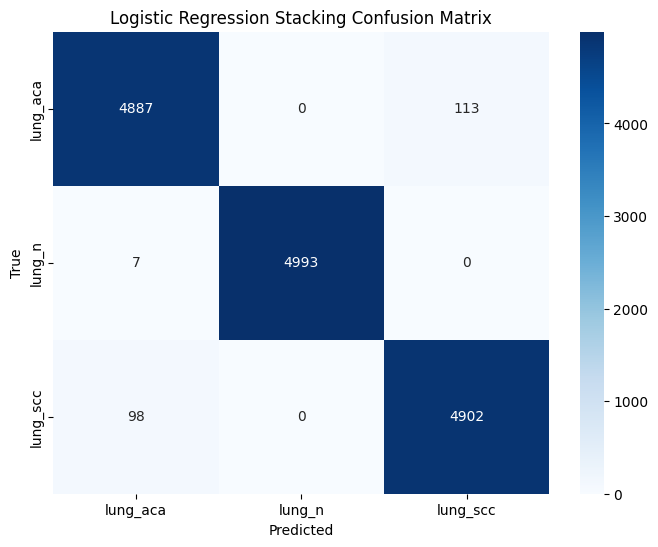

In [13]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Regression Stacking Confusion Matrix')
plt.show()

In [14]:
# Classification report
print("\nClassification Report:\n", classification_report(y_val, ensemble_preds, target_names=validation_generator.class_indices.keys()))


Classification Report:
               precision    recall  f1-score   support

    lung_aca       0.98      0.98      0.98      5000
      lung_n       1.00      1.00      1.00      5000
    lung_scc       0.98      0.98      0.98      5000

    accuracy                           0.99     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       0.99      0.99      0.99     15000



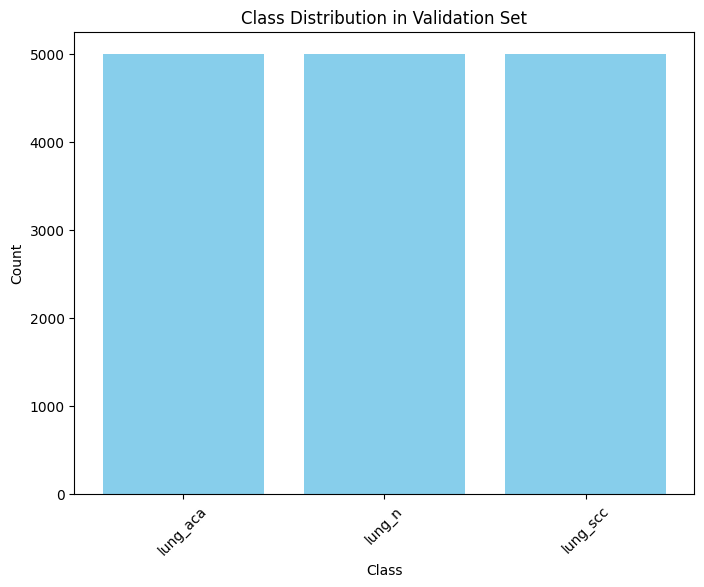

In [57]:
# Visualize class distribution
class_names = list(validation_generator.class_indices.keys())
class_counts = [np.sum(y_val == i) for i in range(len(class_names))]

plt.figure(figsize=(8, 6))
plt.bar(class_names, class_counts, color='skyblue')
plt.title('Class Distribution in Validation Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Training Set Images:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


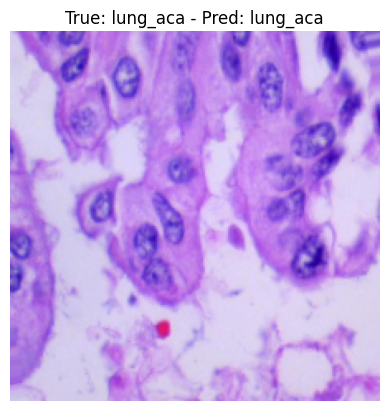

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


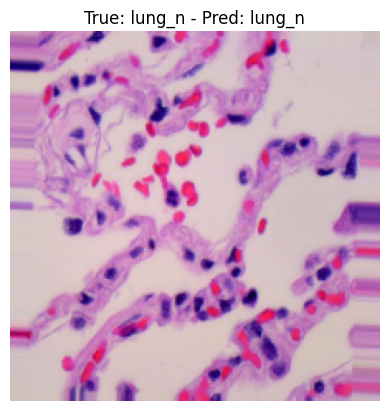

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


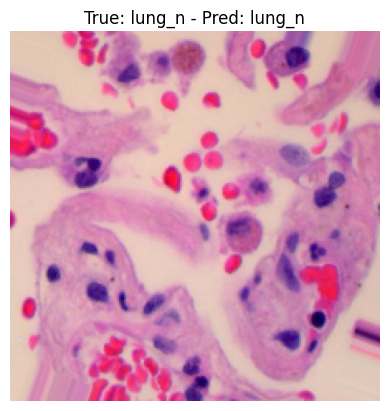

Validation Set Images:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


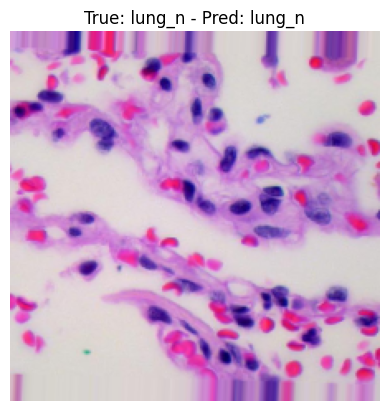

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


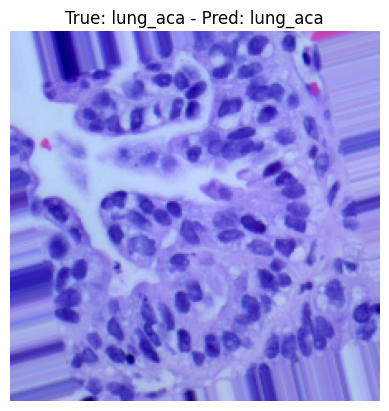

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


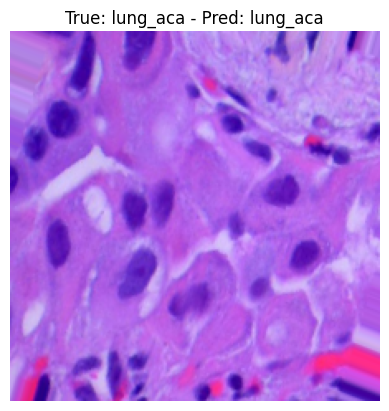

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


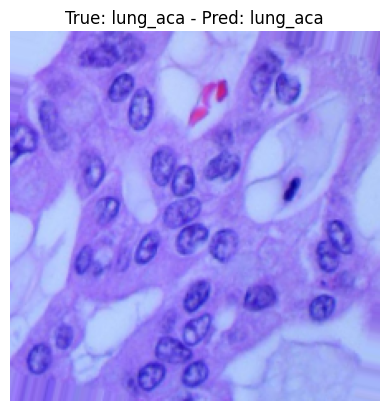

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


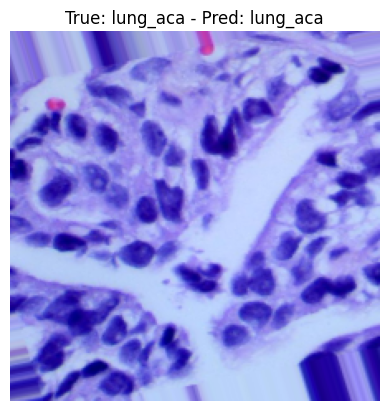

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


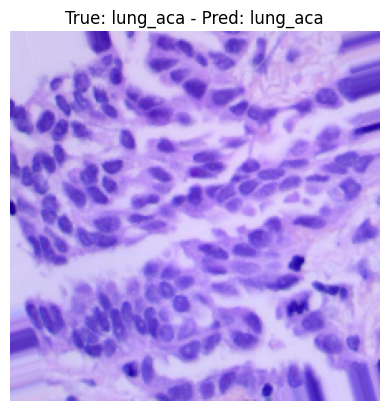

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


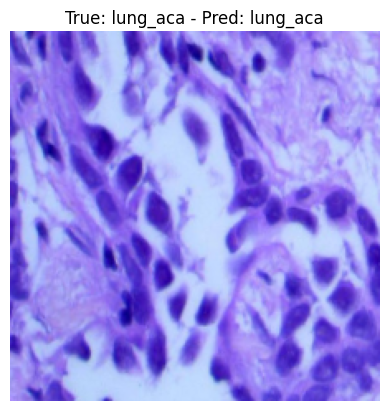

In [68]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Get the class names from the generator's class_indices
class_names = list(validation_generator.class_indices.keys())

# Randomly select 3 images from the training set
train_indices = random.sample(range(len(train_generator)), 3)

# Randomly select 7 images from the validation set
val_indices = random.sample(range(len(validation_generator)), 7)

# Visualize images from training set
print("Training Set Images:")
for idx in train_indices:
    # Get image and true labels from training generator
    img_batch, true_labels_batch = train_generator[idx]  # A batch of images and corresponding labels
    true_label = true_labels_batch[0]  # Get the true label of the first image in the batch
    true_class = class_names[np.argmax(true_label)]  # Convert label to class name

    # Predict using the ensemble model
    pred_label = ensemble_model.predict(np.expand_dims(img_batch[0], axis=0))  # Predict with ensemble model
    pred_class = class_names[np.argmax(pred_label)]  # Convert prediction to class name

    # Visualize the image
    plt.imshow(img_batch[0])  # Only need the first image in the batch
    plt.title(f'True: {true_class} - Pred: {pred_class}')
    plt.axis('off')
    plt.show()

# Visualize images from validation set
print("Validation Set Images:")
for idx in val_indices:
    # Get image and true labels from validation generator
    img_batch, true_labels_batch = validation_generator[idx]  # A batch of images and corresponding labels
    true_label = true_labels_batch[0]  # Get the true label of the first image in the batch
    true_class = class_names[np.argmax(true_label)]  # Convert label to class name

    # Predict using the ensemble model
    pred_label = ensemble_model.predict(np.expand_dims(img_batch[0], axis=0))  # Predict with ensemble model
    pred_class = class_names[np.argmax(pred_label)]  # Convert prediction to class name

    # Visualize the image
    plt.imshow(img_batch[0])  # Only need the first image in the batch
    plt.title(f'True: {true_class} - Pred: {pred_class}')
    plt.axis('off')
    plt.show()


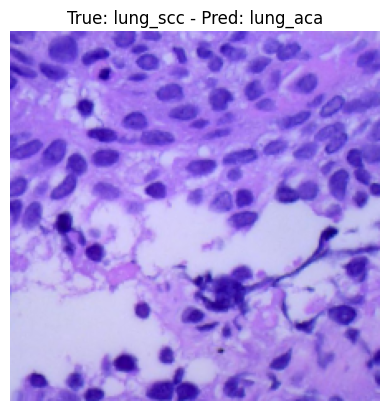

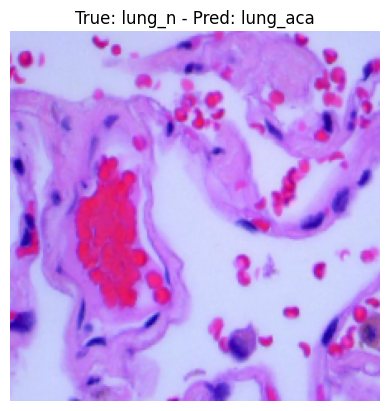

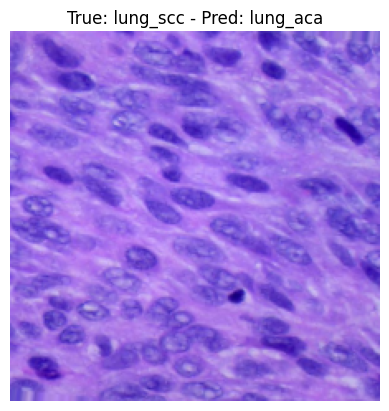

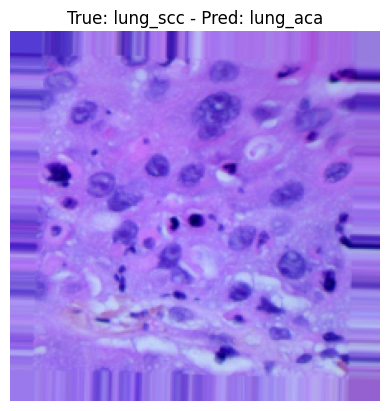

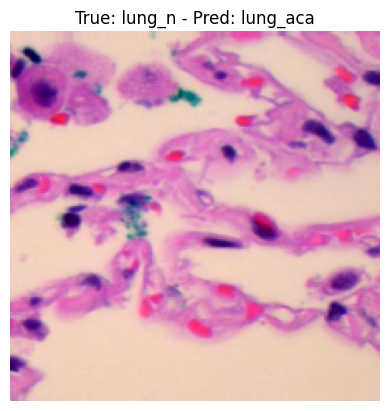

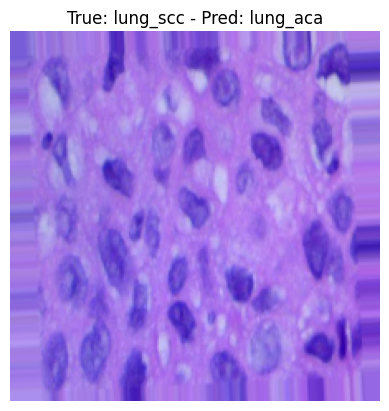

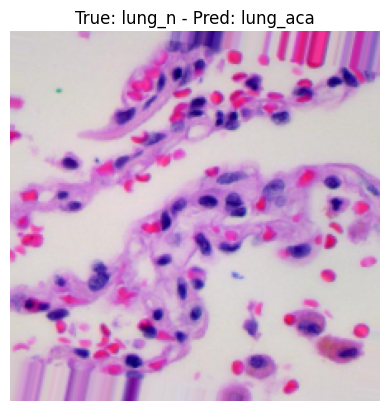

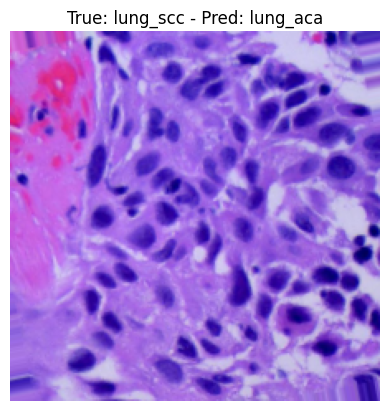

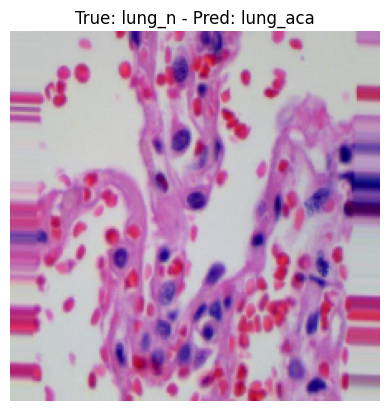

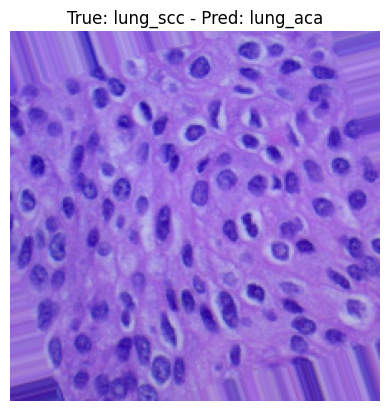

In [61]:
# Get the class names from the generator's class_indices
class_names = list(validation_generator.class_indices.keys())

# Sample indices for visualizing misclassified images
misclassified_indices = []

for i in range(batch_size):
    if np.argmax(ensemble_preds_batch[i]) != np.argmax(labels[i]):
        misclassified_indices.append(i)

# Visualize misclassified images (only show a few to avoid clutter)
for idx in misclassified_indices[:10]:  # Show at most 10 misclassified images
    img = images[idx]
    true_label = np.argmax(labels[idx])  # True label
    pred_label = np.argmax(ensemble_preds_batch[idx])  # Predicted label

    plt.imshow(img)
    plt.title(f'True: {class_names[true_label]} - Pred: {class_names[pred_label]}')
    plt.axis('off')
    plt.show()


In [67]:
# Step 9: Save the complete ensemble model
ensemble_model.save('/content/drive/MyDrive/stacking_ensemble_model.keras')